In [1]:
import requests
import zipfile
import io
import yaml
import pandas as pd
import numpy as np

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    params = {
        "resultformat": "6",
        "queryname": yamlFile["forecast_type"],
        "market_run_id": yamlFile["market_run_id"],
        "execution_type": yamlFile["execution_type"],
        "version": "1",
        "startdatetime": "20240101T08:00-0000",
        "enddatetime": "20240130T08:00-0000"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.content

        zip_data = io.BytesIO(data)
        csv = None
        with zipfile.ZipFile(zip_data, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(file_list)
            for file_name in file_list:
                csv = file_name[:-25]+".csv"
                file_data = zip_ref.read(file_name)
                with open(file_name[:-25]+".csv", 'wb') as file:
                    file.write(file_data)
        return csv
    else:
        print("Request failed with status code:", response.status_code)
        return None

In [10]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]
  TAC_AREA_NAME = yamlFile["TAC_AREA_NAME"]

  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  
  training_set.loc[:, 'training_type'] = 'training'
  validation_set.loc[:, 'training_type'] = 'validation'
  
  return training_set, validation_set

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def limit_display(num_ticks):
  """
  limit display number of x data points
  """
  ax = plt.gca()
  x_ticks = ax.get_xticks()
  x_labels = ax.get_xticklabels()
  step = len(x_ticks) // num_ticks
  ax.set_xticks(x_ticks[::step])
  ax.set_xticklabels(x_labels[::step])
  plt.show()
  
  
def visualization(yamlFile):
  ''' 
  visualize for certain data
  '''
  csv = generate_data(yamlFile)
  training_set, validation_set = split_data(csv, yamlFile)
  wholedata = pd.concat([training_set, validation_set])
  wholedata = wholedata.sort_values(by="INTERVALSTARTTIME_GMT")
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW", hue="training_type", kind="line", height=4, aspect=4)
  label = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  plot.fig.suptitle(label)
  limit_display(5)
  os.remove(csv)

['20240101_20240130_SLD_FCST_ACTUAL_20240313_13_55_25_v1.csv']


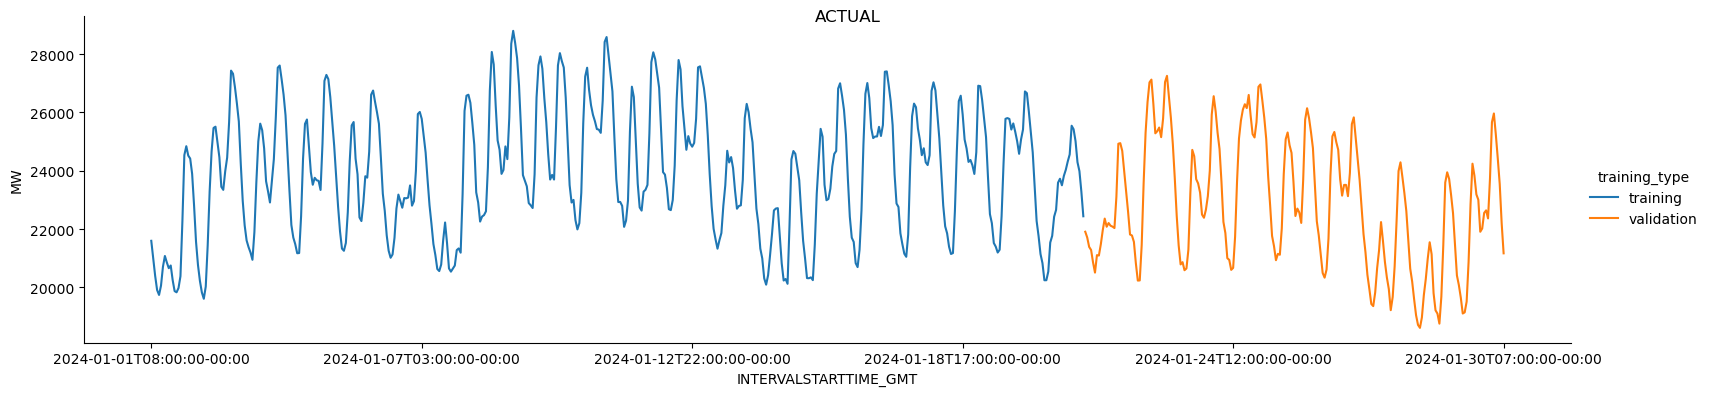

['20240101_20240130_SLD_FCST_DAM_20240313_13_55_28_v1.csv']


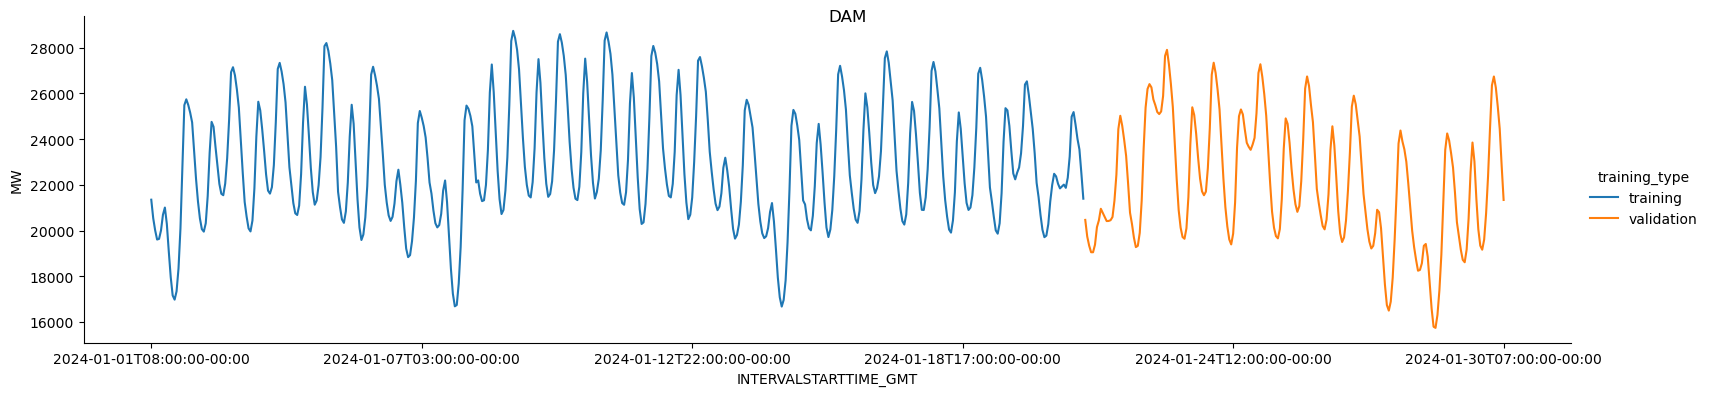

['20240101_20240130_SLD_FCST_RTM_20240313_13_55_32_v1.csv']


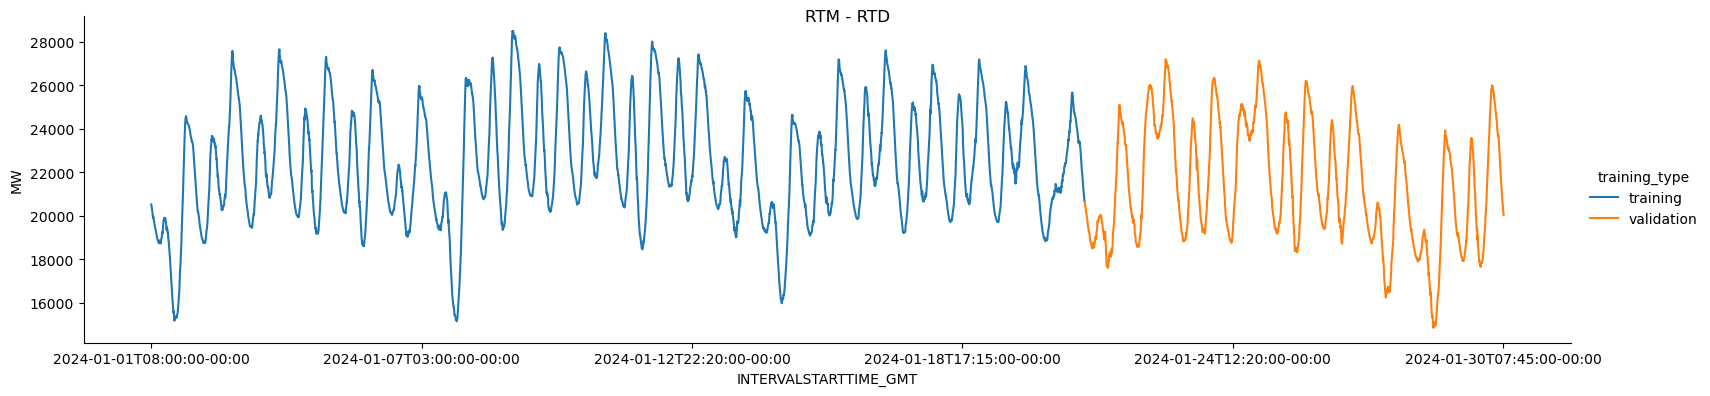

['20240101_20240130_SLD_FCST_RTM_20240313_13_56_16_v1.csv']


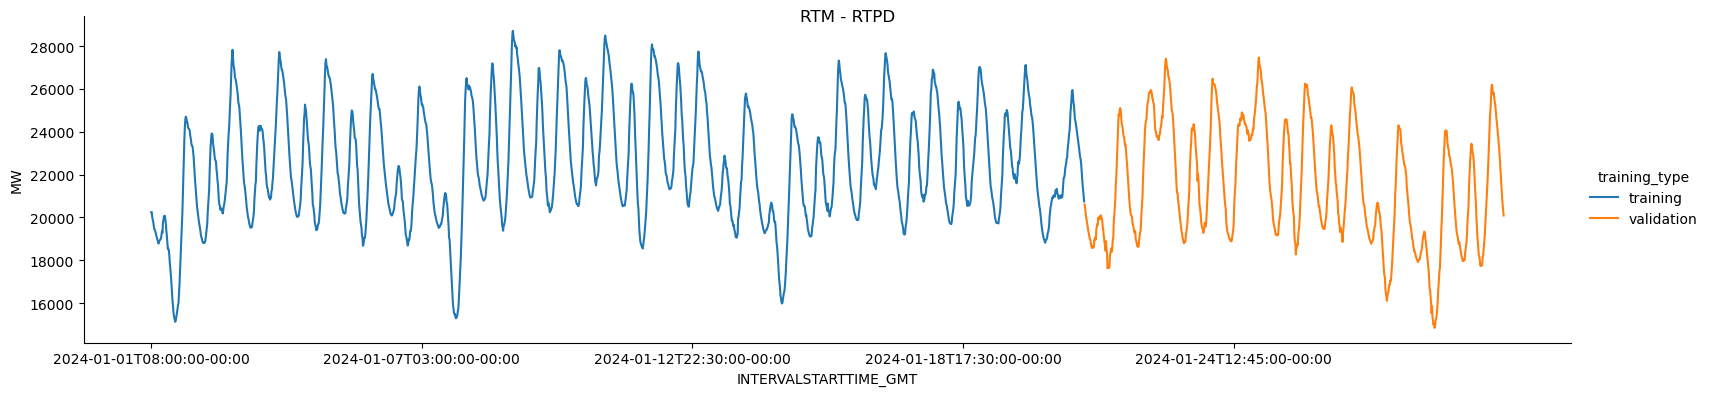

In [15]:
import warnings
warnings.filterwarnings('ignore')


with open("config.yaml") as file:
  yamlFile = yaml.safe_load(file)

visualize_id = yamlFile['visualize_id']
for run_id in visualize_id:
  if not visualize_id[run_id]:
    yamlFile['market_run_id'] = run_id
    yamlFile['execution_type'] = None
    with open('config.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    visualization(yamlFile)

  else:
    for exec_type in visualize_id[run_id]:
      yamlFile['market_run_id'] = run_id
      yamlFile['execution_type'] = exec_type
      with open('config.yaml', 'w') as conf:
        yaml.dump(yamlFile, conf)
      visualization(yamlFile)
    

['20240101_20240130_SLD_FCST_ACTUAL_20240313_14_15_07_v1.csv']
['20240101_20240130_SLD_FCST_RTM_20240313_14_15_08_v1.csv']


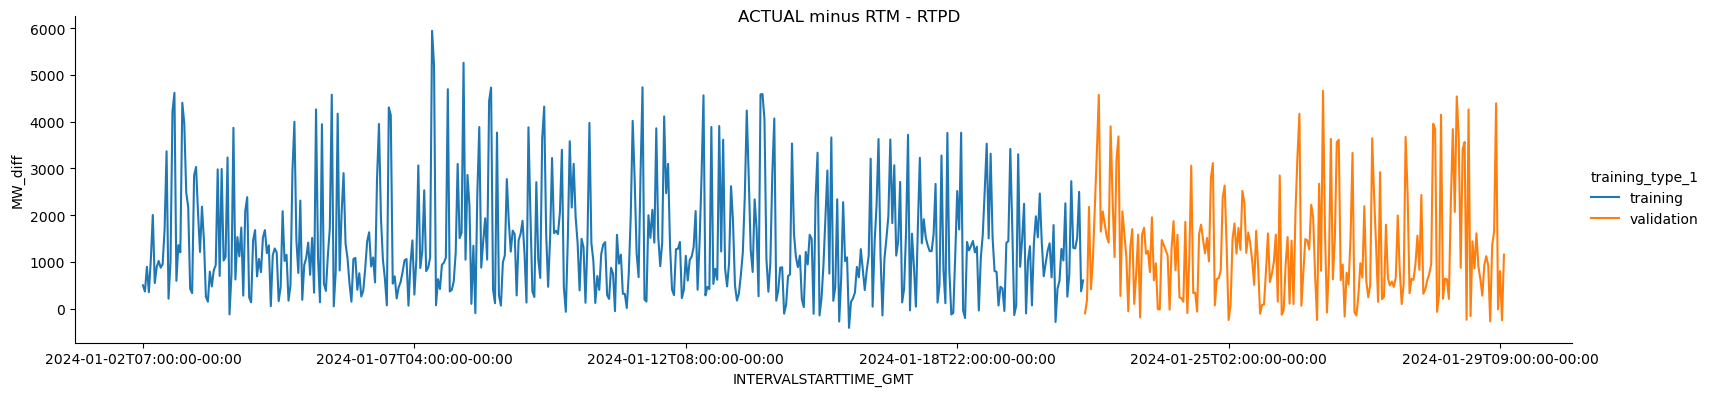

['20240101_20240130_SLD_FCST_DAM_20240313_14_15_14_v1.csv']
['20240101_20240130_SLD_FCST_ACTUAL_20240313_14_15_16_v1.csv']


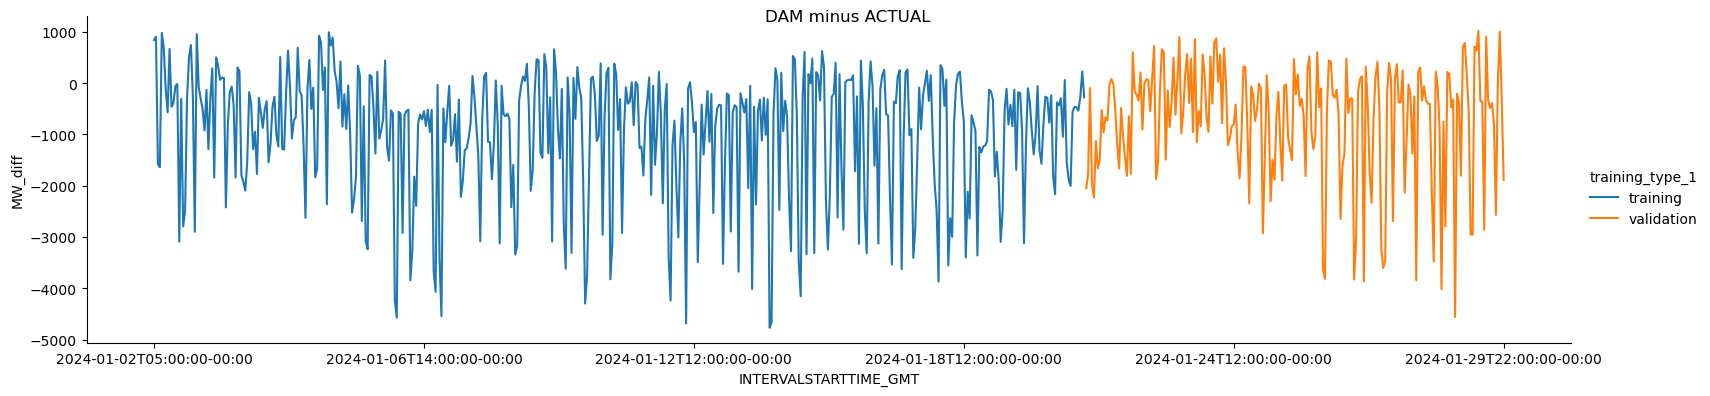

['20240101_20240130_SLD_FCST_RTM_20240313_14_15_20_v1.csv']
['20240101_20240130_SLD_FCST_RTM_20240313_14_15_25_v1.csv']


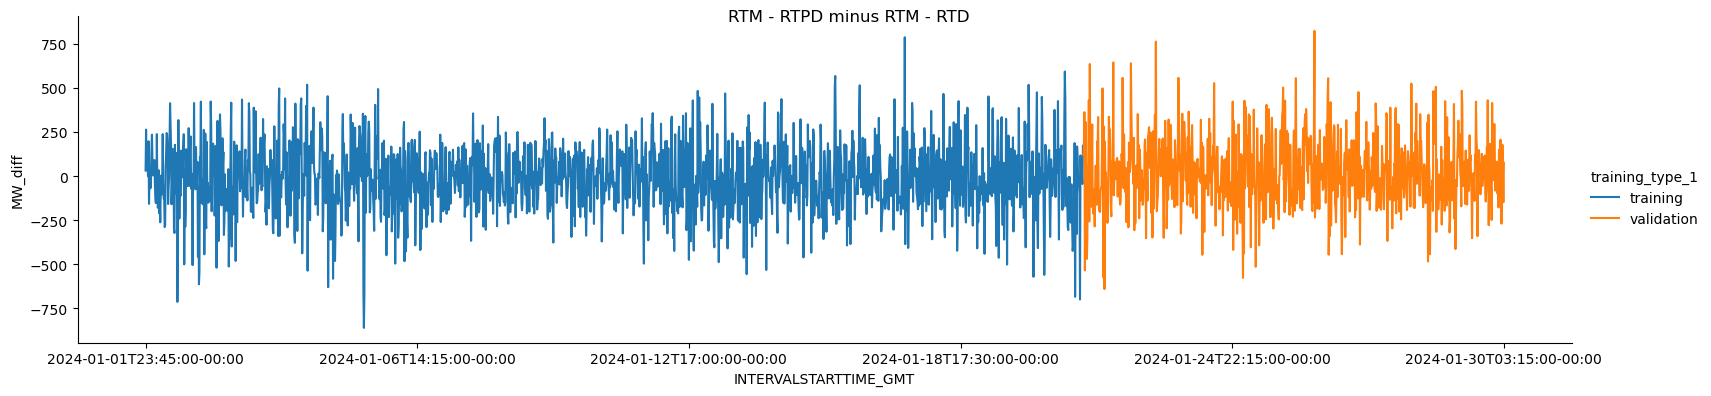

['20240101_20240130_SLD_FCST_RTM_20240313_14_15_45_v1.csv']
['20240101_20240130_SLD_FCST_ACTUAL_20240313_14_15_49_v1.csv']


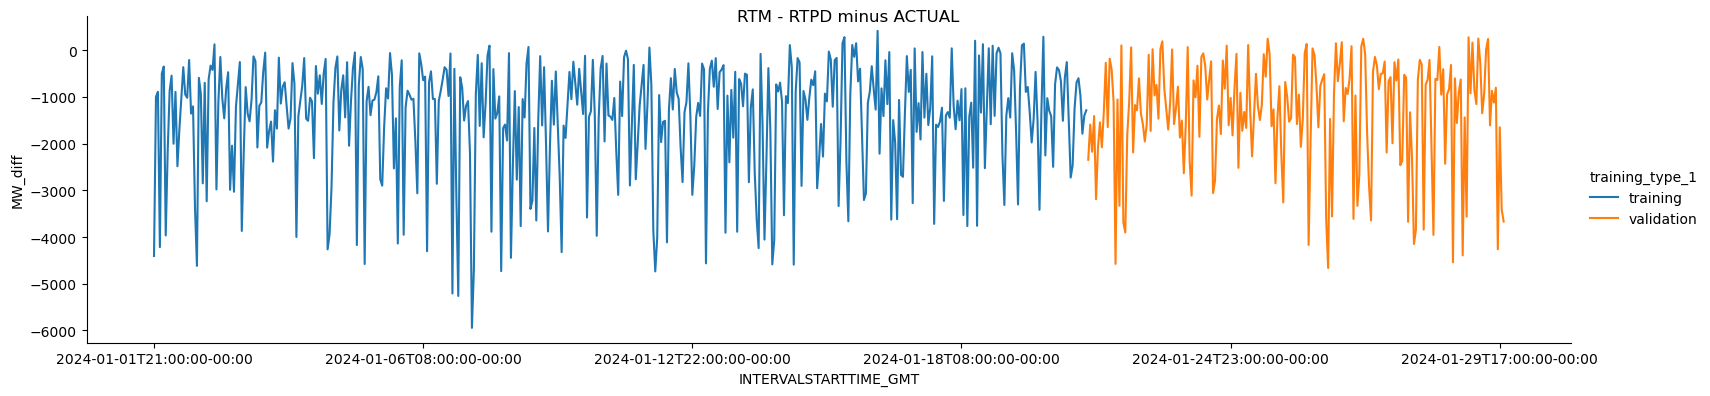

['20240101_20240130_SLD_FCST_RTM_20240313_14_15_54_v1.csv']
['20240101_20240130_SLD_FCST_ACTUAL_20240313_14_16_07_v1.csv']


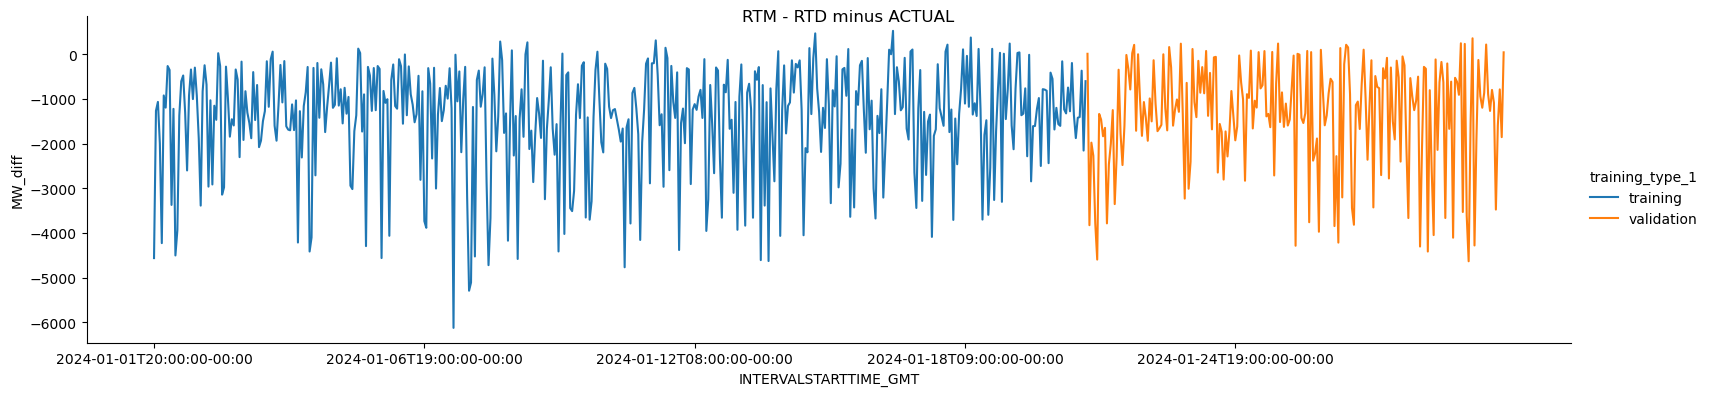

In [24]:

with open("config.yaml") as file:
  yamlFile = yaml.safe_load(file)

minus_visualize_id = yamlFile['minus_visualize']
for minus_list in minus_visualize_id:
  yamlFile['market_run_id'] = minus_list[0]
  yamlFile['execution_type'] = minus_list[1]
  with open('config.yaml', 'w') as conf:
    yaml.dump(yamlFile, conf)
  csv = generate_data(yamlFile)
  training_set, validation_set = split_data(csv, yamlFile)
  wholedata1 = pd.concat([training_set, validation_set])
  os.remove(csv)
  label1 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  
  yamlFile['market_run_id'] = minus_list[2]
  yamlFile['execution_type'] = minus_list[3]
  with open('config.yaml', 'w') as conf:
    yaml.dump(yamlFile, conf)
  csv = generate_data(yamlFile)
  training_set, validation_set = split_data(csv, yamlFile)
  wholedata2 = pd.concat([training_set, validation_set])
  os.remove(csv)
  label2 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  
  wholedata = pd.merge(wholedata1, wholedata2, on='INTERVALSTARTTIME_GMT', suffixes=('_1', '_2'))
  wholedata['MW_diff'] = wholedata['MW_1'] - wholedata['MW_2']
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW_diff", hue="training_type_1", kind="line", height=4, aspect=4)
  plot.fig.suptitle(label1+" minus "+label2)
  limit_display(5)